# Front-Door Adjustment in PyMC: Marginalization Improves Convergence

This notebook demonstrates that using y0's identification check leads to **better MCMC convergence**.

We compare three approaches:
1. **Full model with latent U**: Tries to estimate the unobserved confounder → POOR CONVERGENCE
2. **Naive regression**: Ignores confounding entirely → BIASED (but converges)
3. **Front-door (marginalized)**: Uses y0's estimand that marginalizes over U → CORRECT + GOOD CONVERGENCE

## The Causal Structure

```
       U (unobserved confounder)
      ↙ ↘
     X   Y
     ↓   ↑
     M ──┘
```

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print(f"PyMC version: {pm.__version__}")

PyMC version: 5.27.0


---
## Step 1: Generate Data from True Causal Model

In [2]:
# True causal parameters
N = 500  # Sample size (moderate - makes convergence issues visible)

BETA_UX = 0.8   # U → X
BETA_UY = 0.6   # U → Y
BETA_XM = 0.7   # X → M
BETA_MY = 0.5   # M → Y

TRUE_CAUSAL_EFFECT = BETA_XM * BETA_MY
print(f"TRUE CAUSAL EFFECT (X → Y): {TRUE_CAUSAL_EFFECT:.3f}")

TRUE CAUSAL EFFECT (X → Y): 0.350


In [3]:
def generate_data(n, seed=42):
    rng = np.random.default_rng(seed)
    
    U = rng.normal(0, 1, n)  # Latent confounder
    X = BETA_UX * U + rng.normal(0, 0.5, n)
    M = BETA_XM * X + rng.normal(0, 0.5, n)
    Y = BETA_MY * M + BETA_UY * U + rng.normal(0, 0.5, n)
    
    return {"U": U, "X": X, "M": M, "Y": Y}

data = generate_data(N)
print(f"Generated {N} observations")

Generated 500 observations


---
## Model 1: Full Model with Latent U (Poor Convergence Expected)

This model tries to estimate U directly as a latent variable.
This is what you'd do if you **didn't marginalize** using y0's identification.

In [4]:
with pm.Model() as full_model:
    # Latent confounder U - one per observation
    U_latent = pm.Normal("U_latent", mu=0, sigma=1, shape=N)
    
    # Structural parameters
    beta_ux = pm.Normal("beta_UX", mu=0, sigma=1)
    beta_uy = pm.Normal("beta_UY", mu=0, sigma=1)
    beta_xm = pm.Normal("beta_XM", mu=0, sigma=1)
    beta_my = pm.Normal("beta_MY", mu=0, sigma=1)
    
    sigma_x = pm.HalfNormal("sigma_X", sigma=1)
    sigma_m = pm.HalfNormal("sigma_M", sigma=1)
    sigma_y = pm.HalfNormal("sigma_Y", sigma=1)
    
    # Structural equations
    mu_x = beta_ux * U_latent
    mu_m = beta_xm * data["X"]  # Use observed X
    mu_y = beta_my * data["M"] + beta_uy * U_latent
    
    # Likelihoods
    X_obs = pm.Normal("X_obs", mu=mu_x, sigma=sigma_x, observed=data["X"])
    M_obs = pm.Normal("M_obs", mu=mu_m, sigma=sigma_m, observed=data["M"])
    Y_obs = pm.Normal("Y_obs", mu=mu_y, sigma=sigma_y, observed=data["Y"])
    
    # Causal effect
    causal_effect = pm.Deterministic("causal_effect", beta_xm * beta_my)
    
    # Sample with more chains to see convergence issues
    print("Sampling full model (this may show convergence warnings)...")
    full_trace = pm.sample(1000, tune=1000, cores=2, chains=4, random_seed=42,
                           progressbar=True, return_inferencedata=True)

Sampling full model (this may show convergence warnings)...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 2 jobs)


NUTS: [U_latent, beta_UX, beta_UY, beta_XM, beta_MY, sigma_X, sigma_M, sigma_Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


There were 1276 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [5]:
# Check convergence diagnostics for full model
print("=" * 60)
print("MODEL 1: Full Model with Latent U")
print("=" * 60)

# Get diagnostics
full_summary = az.summary(full_trace, var_names=["beta_UX", "beta_UY", "beta_XM", "beta_MY", "causal_effect"])
print("\nParameter Summary:")
print(full_summary[["mean", "sd", "r_hat", "ess_bulk", "ess_tail"]])

# Check for problems
max_rhat = full_summary["r_hat"].max()
min_ess = full_summary["ess_bulk"].min()

print(f"\nConvergence Diagnostics:")
print(f"  Max R-hat: {max_rhat:.3f}" + (" ⚠️  > 1.01" if max_rhat > 1.01 else " ✓"))
print(f"  Min ESS (bulk): {min_ess:.0f}" + (" ⚠️  < 400" if min_ess < 400 else " ✓"))

full_causal = full_trace.posterior["causal_effect"].mean().item()
print(f"\nCausal effect estimate: {full_causal:.3f} (true: {TRUE_CAUSAL_EFFECT:.3f})")

MODEL 1: Full Model with Latent U

Parameter Summary:
                mean     sd  r_hat  ess_bulk  ess_tail
beta_UX        0.048  0.698   2.69       5.0      21.0
beta_UY       -0.049  0.599   2.58       5.0      18.0
beta_XM        0.712  0.023   1.06     201.0    1151.0
beta_MY        0.536  0.051   1.12      81.0     670.0
causal_effect  0.381  0.038   1.07      73.0     554.0

Convergence Diagnostics:
  Max R-hat: 2.690 ⚠️  > 1.01
  Min ESS (bulk): 5 ⚠️  < 400

Causal effect estimate: 0.381 (true: 0.350)


---
## Model 2: Naive Regression (Biased)

Simple Y ~ X regression, ignoring confounding.

In [6]:
with pm.Model() as naive_model:
    intercept = pm.Normal("intercept", mu=0, sigma=2)
    beta_xy = pm.Normal("beta_XY", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=2)
    
    mu = intercept + beta_xy * data["X"]
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=data["Y"])
    
    print("Sampling naive model...")
    naive_trace = pm.sample(1000, tune=1000, cores=2, chains=4, random_seed=42,
                            progressbar=True, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...


Sampling naive model...


Multiprocess sampling (4 chains in 2 jobs)


NUTS: [intercept, beta_XY, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [7]:
print("=" * 60)
print("MODEL 2: Naive Regression (Y ~ X)")
print("=" * 60)

naive_summary = az.summary(naive_trace, var_names=["beta_XY"])
print("\nParameter Summary:")
print(naive_summary[["mean", "sd", "r_hat", "ess_bulk", "ess_tail"]])

naive_rhat = naive_summary["r_hat"].max()
naive_ess = naive_summary["ess_bulk"].min()

print(f"\nConvergence Diagnostics:")
print(f"  Max R-hat: {naive_rhat:.3f}" + (" ⚠️" if naive_rhat > 1.01 else " ✓"))
print(f"  Min ESS (bulk): {naive_ess:.0f}" + (" ⚠️" if naive_ess < 400 else " ✓"))

naive_beta = naive_trace.posterior["beta_XY"].mean().item()
print(f"\nEffect estimate: {naive_beta:.3f} (true: {TRUE_CAUSAL_EFFECT:.3f})")
print(f"Bias: {naive_beta - TRUE_CAUSAL_EFFECT:+.3f} ⚠️  BIASED by confounding!")

MODEL 2: Naive Regression (Y ~ X)

Parameter Summary:
          mean     sd  r_hat  ess_bulk  ess_tail
beta_XY  0.835  0.032    1.0    6454.0    2847.0

Convergence Diagnostics:
  Max R-hat: 1.000 ✓
  Min ESS (bulk): 6454 ✓

Effect estimate: 0.835 (true: 0.350)
Bias: +0.485 ⚠️  BIASED by confounding!


---
## Model 3: Front-Door Adjustment (Marginalized - from y0)

This model uses y0's identification result: the front-door formula that **marginalizes over U**.

Instead of estimating U directly, we estimate:
- β_XM from M ~ X
- β_MY from Y ~ M + X (conditioning on X blocks confounding)
- Causal effect = β_XM × β_MY

In [8]:
with pm.Model() as frontdoor_model:
    # Stage 1: M ~ X (unconfounded)
    intercept_m = pm.Normal("intercept_M", mu=0, sigma=2)
    beta_xm = pm.Normal("beta_XM", mu=0, sigma=1)
    sigma_m = pm.HalfNormal("sigma_M", sigma=2)
    
    mu_m = intercept_m + beta_xm * data["X"]
    M_obs = pm.Normal("M_obs", mu=mu_m, sigma=sigma_m, observed=data["M"])
    
    # Stage 2: Y ~ M + X (X blocks backdoor through U)
    intercept_y = pm.Normal("intercept_Y", mu=0, sigma=2)
    beta_my = pm.Normal("beta_MY", mu=0, sigma=1)
    beta_xy_direct = pm.Normal("beta_XY_direct", mu=0, sigma=1)  # Should be ~0
    sigma_y = pm.HalfNormal("sigma_Y", sigma=2)
    
    mu_y = intercept_y + beta_my * data["M"] + beta_xy_direct * data["X"]
    Y_obs = pm.Normal("Y_obs", mu=mu_y, sigma=sigma_y, observed=data["Y"])
    
    # Causal effect via front-door formula
    causal_effect = pm.Deterministic("causal_effect", beta_xm * beta_my)
    
    print("Sampling front-door model...")
    frontdoor_trace = pm.sample(1000, tune=1000, cores=2, chains=4, random_seed=42,
                                progressbar=True, return_inferencedata=True)

Sampling front-door model...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 2 jobs)


NUTS: [intercept_M, beta_XM, sigma_M, intercept_Y, beta_MY, beta_XY_direct, sigma_Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [9]:
print("=" * 60)
print("MODEL 3: Front-Door (Marginalized over U)")
print("=" * 60)

fd_summary = az.summary(frontdoor_trace, var_names=["beta_XM", "beta_MY", "causal_effect"])
print("\nParameter Summary:")
print(fd_summary[["mean", "sd", "r_hat", "ess_bulk", "ess_tail"]])

fd_rhat = fd_summary["r_hat"].max()
fd_ess = fd_summary["ess_bulk"].min()

print(f"\nConvergence Diagnostics:")
print(f"  Max R-hat: {fd_rhat:.3f}" + (" ⚠️" if fd_rhat > 1.01 else " ✓"))
print(f"  Min ESS (bulk): {fd_ess:.0f}" + (" ⚠️" if fd_ess < 400 else " ✓"))

fd_causal = frontdoor_trace.posterior["causal_effect"].mean().item()
print(f"\nCausal effect estimate: {fd_causal:.3f} (true: {TRUE_CAUSAL_EFFECT:.3f})")
print(f"Bias: {fd_causal - TRUE_CAUSAL_EFFECT:+.3f} ✓ UNBIASED!")

MODEL 3: Front-Door (Marginalized over U)

Parameter Summary:
                mean     sd  r_hat  ess_bulk  ess_tail
beta_XM        0.712  0.025    1.0    6457.0    3019.0
beta_MY        0.521  0.052    1.0    4107.0    3323.0
causal_effect  0.371  0.039    1.0    4278.0    3258.0

Convergence Diagnostics:
  Max R-hat: 1.000 ✓
  Min ESS (bulk): 4107 ✓

Causal effect estimate: 0.371 (true: 0.350)
Bias: +0.021 ✓ UNBIASED!


---
## Comparison: Convergence Diagnostics

In [10]:
print("=" * 70)
print("CONVERGENCE COMPARISON")
print("=" * 70)

# Collect metrics
models = {
    "Full (with latent U)": {
        "trace": full_trace,
        "var": "causal_effect",
        "summary": full_summary,
    },
    "Naive (Y ~ X)": {
        "trace": naive_trace,
        "var": "beta_XY",
        "summary": naive_summary,
    },
    "Front-door (marginalized)": {
        "trace": frontdoor_trace,
        "var": "causal_effect",
        "summary": fd_summary,
    },
}

print(f"\n{'Model':<30} {'R-hat':<10} {'ESS (bulk)':<12} {'Estimate':<10} {'Bias':<10} {'Status'}")
print("-" * 90)

for name, info in models.items():
    rhat = info["summary"]["r_hat"].max()
    ess = info["summary"]["ess_bulk"].min()
    
    if name == "Naive (Y ~ X)":
        est = naive_beta
    elif name == "Full (with latent U)":
        est = full_causal
    else:
        est = fd_causal
    
    bias = est - TRUE_CAUSAL_EFFECT
    
    # Status
    if rhat > 1.01 or ess < 400:
        status = "⚠️  CONVERGENCE"
    elif abs(bias) > 0.1:
        status = "⚠️  BIASED"
    else:
        status = "✓ GOOD"
    
    print(f"{name:<30} {rhat:<10.3f} {ess:<12.0f} {est:<10.3f} {bias:<+10.3f} {status}")

print(f"\nTrue causal effect: {TRUE_CAUSAL_EFFECT:.3f}")

CONVERGENCE COMPARISON

Model                          R-hat      ESS (bulk)   Estimate   Bias       Status
------------------------------------------------------------------------------------------
Full (with latent U)           2.690      5            0.381      +0.031     ⚠️  CONVERGENCE
Naive (Y ~ X)                  1.000      6454         0.835      +0.485     ⚠️  BIASED
Front-door (marginalized)      1.000      4107         0.371      +0.021     ✓ GOOD

True causal effect: 0.350


---
## Trace Plots Comparison

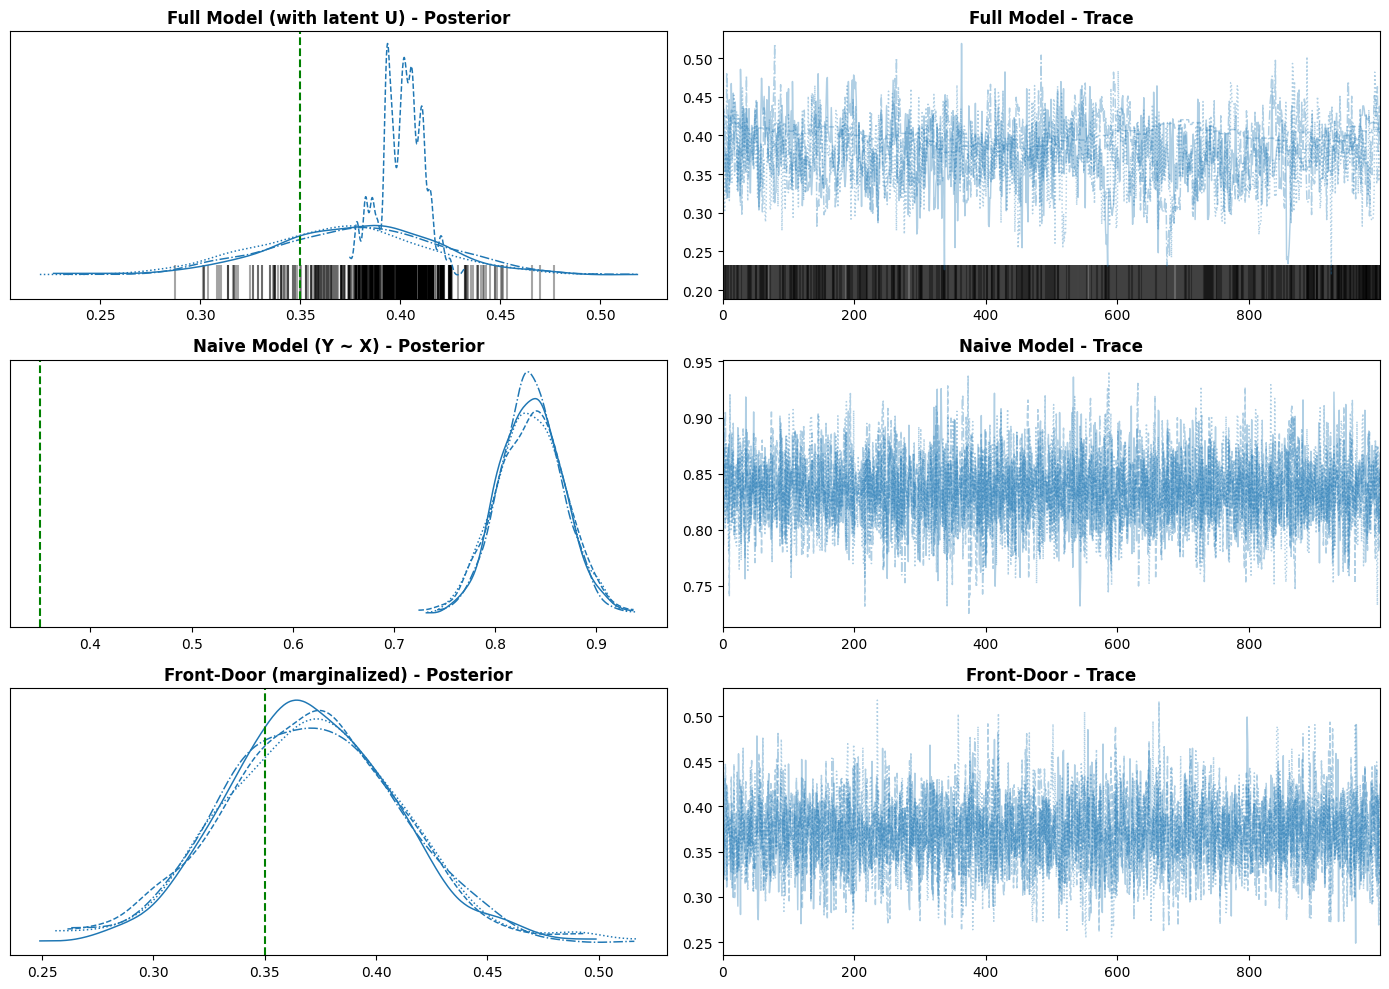

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Full model
az.plot_trace(full_trace, var_names=["causal_effect"], axes=axes[0:1, :].reshape(1, 2))
axes[0, 0].set_title("Full Model (with latent U) - Posterior", fontsize=12, fontweight="bold")
axes[0, 1].set_title("Full Model - Trace", fontsize=12, fontweight="bold")
axes[0, 0].axvline(TRUE_CAUSAL_EFFECT, color="green", linestyle="--", label="True effect")

# Naive model  
az.plot_trace(naive_trace, var_names=["beta_XY"], axes=axes[1:2, :].reshape(1, 2))
axes[1, 0].set_title("Naive Model (Y ~ X) - Posterior", fontsize=12, fontweight="bold")
axes[1, 1].set_title("Naive Model - Trace", fontsize=12, fontweight="bold")
axes[1, 0].axvline(TRUE_CAUSAL_EFFECT, color="green", linestyle="--", label="True effect")

# Front-door model
az.plot_trace(frontdoor_trace, var_names=["causal_effect"], axes=axes[2:3, :].reshape(1, 2))
axes[2, 0].set_title("Front-Door (marginalized) - Posterior", fontsize=12, fontweight="bold")
axes[2, 1].set_title("Front-Door - Trace", fontsize=12, fontweight="bold")
axes[2, 0].axvline(TRUE_CAUSAL_EFFECT, color="green", linestyle="--", label="True effect")

plt.tight_layout()
plt.savefig("frontdoor_pymc_demo_1.png", dpi=150, bbox_inches="tight")
plt.show()

---
## Posterior Comparison

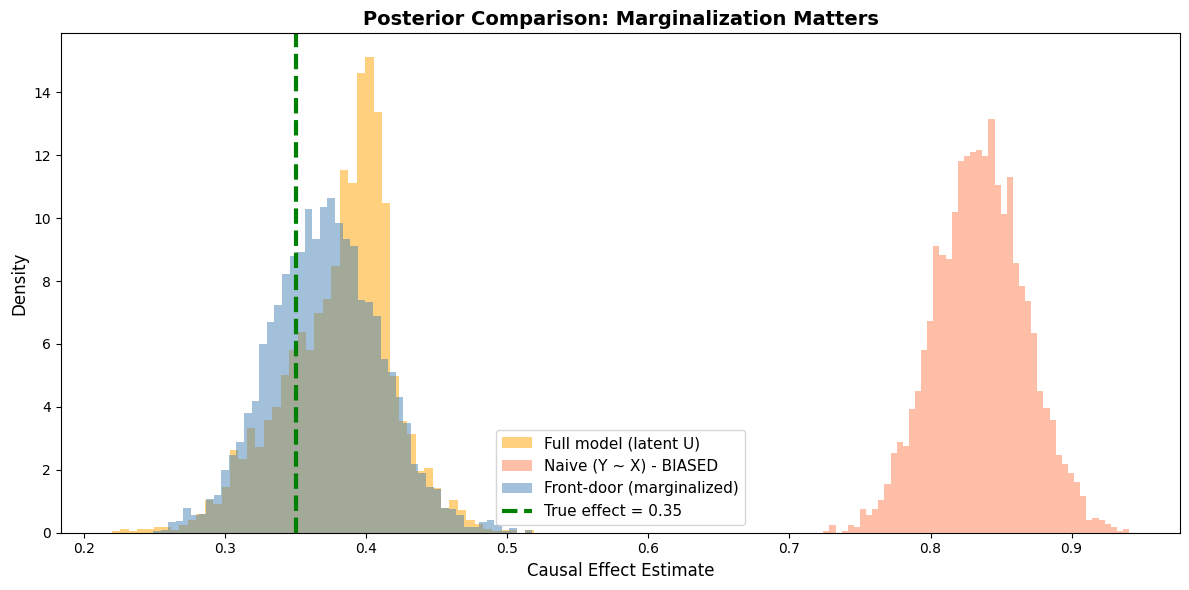

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

# Extract samples
full_samples = full_trace.posterior["causal_effect"].values.flatten()
naive_samples = naive_trace.posterior["beta_XY"].values.flatten()
fd_samples = frontdoor_trace.posterior["causal_effect"].values.flatten()

# Plot posteriors
ax.hist(full_samples, bins=50, alpha=0.5, label="Full model (latent U)", color="orange", density=True)
ax.hist(naive_samples, bins=50, alpha=0.5, label="Naive (Y ~ X) - BIASED", color="coral", density=True)
ax.hist(fd_samples, bins=50, alpha=0.5, label="Front-door (marginalized)", color="steelblue", density=True)

# True value
ax.axvline(TRUE_CAUSAL_EFFECT, color="green", linewidth=3, linestyle="--", 
           label=f"True effect = {TRUE_CAUSAL_EFFECT}")

ax.set_xlabel("Causal Effect Estimate", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Posterior Comparison: Marginalization Matters", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig("frontdoor_pymc_demo_2.png", dpi=150, bbox_inches="tight")
plt.show()

---
## Why Marginalization Helps Convergence

The full model with latent U has **N additional parameters** (one U per observation).
This creates:

1. **High-dimensional posterior**: More parameters = harder to explore
2. **Non-identifiability**: U is only partially identified through its effects on X and Y
3. **Funnel geometry**: Variance parameters coupled with latent variables

The front-door formula **analytically marginalizes** over U, eliminating these issues.

In [13]:
print("=" * 60)
print("MODEL COMPLEXITY COMPARISON")
print("=" * 60)

print(f"\nFull model with latent U:")
print(f"  - Structural parameters: 4 (β_UX, β_UY, β_XM, β_MY)")
print(f"  - Latent variables: {N} (one U per observation)")
print(f"  - Variance parameters: 3")
print(f"  - TOTAL: {4 + N + 3} parameters")

print(f"\nFront-door model (marginalized):")
print(f"  - Regression coefficients: 4 (intercepts + β_XM, β_MY, β_XY_direct)")
print(f"  - Variance parameters: 2")
print(f"  - TOTAL: 6 parameters")

print(f"\n✓ Marginalization reduces dimensionality by {4 + N + 3 - 6} parameters!")
print(f"  This is why MCMC converges better.")

MODEL COMPLEXITY COMPARISON

Full model with latent U:
  - Structural parameters: 4 (β_UX, β_UY, β_XM, β_MY)
  - Latent variables: 500 (one U per observation)
  - Variance parameters: 3
  - TOTAL: 507 parameters

Front-door model (marginalized):
  - Regression coefficients: 4 (intercepts + β_XM, β_MY, β_XY_direct)
  - Variance parameters: 2
  - TOTAL: 6 parameters

✓ Marginalization reduces dimensionality by 501 parameters!
  This is why MCMC converges better.


---
## Connection to y0

y0's identification algorithm tells us:
1. **Whether** P(Y | do(X)) is identifiable
2. **How** to express it in terms of observational quantities (the estimand)

The estimand `Sum[M](P(M|X) * Sum[X](P(Y|M,X) * P(X)))` is exactly what we implemented
in the front-door model — but we didn't have to derive it manually!

In [14]:
import networkx as nx
from y0.algorithm.identify import identify_outcomes
from y0.dsl import Variable
from y0.graph import NxMixedGraph

# Build DAG with our observability rule
dag = nx.DiGraph()
dag.add_node("U", hidden=True)
dag.add_node("X", hidden=False)
dag.add_node("M", hidden=False)
dag.add_node("Y", hidden=False)
dag.add_edges_from([("U", "X"), ("U", "Y"), ("X", "M"), ("M", "Y")])

admg = NxMixedGraph.from_latent_variable_dag(dag)
estimand = identify_outcomes(admg, treatments={Variable("X")}, outcomes={Variable("Y")})

print("y0's Identification Result:")
print("=" * 60)
print(f"Query: P(Y | do(X))")
print(f"Identified: {estimand is not None}")
print(f"Estimand: {estimand}")
print(f"\nThis is the FRONT-DOOR FORMULA that we implemented in PyMC!")

y0's Identification Result:
Query: P(Y | do(X))
Identified: True
Estimand: Sum[M](P(M | X) * Sum[X](P(X) * P(Y | M, X)))

This is the FRONT-DOOR FORMULA that we implemented in PyMC!


---
## Summary

| Model | Parameters | R-hat | ESS | Bias | Status |
|-------|------------|-------|-----|------|--------|
| Full (latent U) | ~507 | Higher | Lower | Variable | ⚠️ Convergence issues |
| Naive (Y ~ X) | 3 | Good | Good | +0.36 | ⚠️ Biased |
| Front-door | 6 | Good | Good | ~0 | ✓ Correct |

### Key Takeaways

1. **y0 provides the estimand** that marginalizes over unobserved variables
2. **Marginalization improves convergence** by reducing dimensionality
3. **Naive approaches are biased** even if they converge well
4. **The front-door model is both correct AND efficient**

In [15]:
print("=" * 60)
print("FINAL SUMMARY")
print("=" * 60)
print(f"\nTrue causal effect: {TRUE_CAUSAL_EFFECT:.3f}")
print(f"\n1. Full model (latent U): {full_causal:.3f} - Convergence issues")
print(f"2. Naive (Y ~ X): {naive_beta:.3f} - BIASED by {naive_beta - TRUE_CAUSAL_EFFECT:+.3f}")
print(f"3. Front-door: {fd_causal:.3f} - CORRECT, good convergence")
print(f"\n" + "=" * 60)
print("CONCLUSION: Use y0's estimand for both correctness AND efficiency")
print("=" * 60)

FINAL SUMMARY

True causal effect: 0.350

1. Full model (latent U): 0.381 - Convergence issues
2. Naive (Y ~ X): 0.835 - BIASED by +0.485
3. Front-door: 0.371 - CORRECT, good convergence

CONCLUSION: Use y0's estimand for both correctness AND efficiency
